# Neural Network Cell Type Classification of Single-Cell Data


A key deliverable of cell atlas projects is an operational definition of cell type that allows the automated labeling of cells in new datasets. So far, this goal is largely aspirational: single-cell annotation remains a painfully manual task, and insufficient training data and inconsistent labels have limited the utility of previous cell type classification models. However, many millions of cells with standardized labels have recently become available, most notably in the cell x gene Census dataset.

Here, we propose a classification framework that leverages the hierarchical nature of cell ontology labels to probabilistically classify both the cell types and functional properties of unseen cell profiles. Using a simple but powerful technique called marginalization classification for cells (McCells), we will train a model that outputs a probability distribution over the cell ontology for each cell or cluster. Crucially, our approach leverages the hierarchical nature of cell ontology labels during training, ensuring that (1) cells labeled with either general or specific labels contribute; and (2) the label probabilities for each data point obey the conditional independence relationships encoded in the ontology structure. McCells also elegantly models multiple inheritance in the cell ontology and is compatible with a variety of model architectures. Additionally, we will leverage cell ontology annotations of cell functions to predict functional descriptions of cells from gene expression. Ultimately, McCells will allow users to traverse the cell ontology and identify the probability of predicted cell types and functions at varying levels of specificity.


Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- load sc-RNA seq data that has already been downloaded from the CZI CellXGene census
- preprocess the data and the Cell Ontology
- model the data with a custom Pytorch Neural Network
- save and visualize the results



In [1]:
#import cellxgene_census as cell_census
import anndata as ad
import umap

import pronto
import warnings
warnings.filterwarnings("ignore", category=pronto.warnings.ProntoWarning)


import pandas as pd
import numpy as np
from scipy import sparse
import copy
import time
import sys
import os
import pickle
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from torcheval.metrics.functional import multilabel_accuracy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load the data and Cell Ontology. 

Great-lakes does not have internet access, so we pull in the data outside first, then load it here as an AnnData object. The Cell Ontology also needs to be loaded for access. 

In [3]:
# change into scratch directory (where data is saved)
#os.chdir('/scratch/welchjd_root/welchjd99/fujoshua')
os.chdir('/nfs/turbo/umms-welchjd/mccell')

### Load Single Dataset

In [4]:
#adata = ad.read_h5ad('small_1044_900') # 42000 cells
#adata = ad.read_h5ad('leaf_list_in_cl') # 658000 cells
#adata = ad.read_h5ad('leaf_list_leukocyte_24Aug') # 516000 cells, 60k genes
#adata = ad.read_h5ad('leaf_list_leukocyte_6Sep_coding_genes') # 516k cells, 20k genes
#adata = ad.read_h5ad('leaf_list_hematopoietic_14Sep_coding_genes') # 549k cells, 20k genes, upper level hematopoietic (0000988)
#adata = ad.read_h5ad('1044_624_895_27Sep_coding_genes') # 230k cells, only CL1044 (leaf), 624 (internal), and 895 (leaf) including leaf and internal node
#adata = ad.read_h5ad('13Oct_2int_3leaf') #379k cells, 2 internal (576,624), 3 leaf (1044,895,2057)

adata = ad.read_h5ad('24Oct_hematopoietic_cells_p2') # 472k cells, part of the full hema data set
#adata = ad.read_h5ad('24Oct_hematopoietic_cells_p2_subsample') # 47k cells, part of the full hema data set

### Load Multiple Datasets and combine

In [4]:
adata1 = ad.read_h5ad('24Oct_hematopoietic_cells_p1') # 1.98 million cells
adata2 = ad.read_h5ad('24Oct_hematopoietic_cells_p2') # 472k cells



In [5]:
adata = ad.concat([adata1,adata2]) #2.45 million

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
# delete adata1 and adata2 to save memory
del adata1
del adata2

In [13]:
adata

AnnData object with n_obs × n_vars = 2455115 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'

In [14]:
adata1

AnnData object with n_obs × n_vars = 1982772 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [15]:
adata2

AnnData object with n_obs × n_vars = 472343 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [5]:
os.getcwd()

'/nfs/turbo/umms-welchjd/mccell'

### Load the Cell Ontology

You can visualize the ontology using https://www.ebi.ac.uk/ols4/ontologies/cl

And you can download the ontology file here: https://obofoundry.org/ontology/cl.html

In [18]:
os.chdir('/home/fujoshua/cell_classification')

In [5]:
cl = pronto.Ontology.from_obo_library('cl.owl')


## Checking memory allocations



In [20]:
print(torch.cuda.get_device_properties(0).total_memory*1e-9)
print(torch.cuda.memory_reserved()*1e-9)
print(torch.cuda.memory_allocated()*1e-9)
#print(torch.cuda.mem_get_info())


47.674556416
3.4204549120000003
3.401314816


In [15]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


In [17]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                        y_data: 217.4 MiB
                   ontology_df: 128.4 KiB
              ontology_leaf_df: 82.9 KiB
                           _i8:  7.0 KiB
                          _i10:  6.1 KiB
                  mapping_dict:  4.6 KiB
                   parent_dict:  2.2 KiB
                  LabelEncoder:  1.0 KiB
                          _i13:  977.0 B
                           _i1:  952.0 B


In [21]:
del adata

In [14]:
del y_holdout

## Plotting Functions

In [6]:
def plot_results(marginalization_dict,num_epochs,save_title=None):
    fig, ax = plt.subplots(4,2,figsize=(9,12))
    
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_leaf_hist'], 
                    ax = ax[0,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_leaf_hist'], 
                    ax = ax[0,0],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_internal_hist'],
                   ax = ax[0,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_internal_hist'],
                   ax = ax[0,1],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_hist'], 
                    ax = ax[1,0],color='lightcoral')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_hist'], 
                    ax = ax[1,0],color='mediumslateblue')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_leaf_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='X',label='Train Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='o',label='Train Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
    #                ax = ax[1,0],color='lightcoral',marker='v',label='Train Internal')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_leaf_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='X',label='Val Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='o',label='Val Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
    #                ax = ax[1,1],color='mediumslateblue',marker='v',label='Val Internal')


    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_leaf'], 
                    ax = ax[2,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_leaf'], 
                    ax = ax[2,1],color='mediumslateblue',label='Validation')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_internal'], 
                    ax = ax[3,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_internal'], 
                    ax = ax[3,0],color='mediumslateblue',label='Validation')

    
    ax[0,0].set_xlabel('Epoch')
    ax[0,1].set_xlabel('Epoch')
    ax[1,0].set_xlabel('Epoch')
    ax[1,1].set_xlabel('Epoch')
    ax[2,0].set_xlabel('Epoch')
    ax[2,1].set_xlabel('Epoch')
    ax[3,0].set_xlabel('Epoch')


    ax[0,0].set_ylabel('Leaf Accuracy')
    ax[0,1].set_ylabel('Internal Accuracy')
    ax[1,0].set_ylabel('Total Loss')
    ax[1,1].set_ylabel('Training Loss')
    ax[2,0].set_ylabel('Validation Loss')
    ax[2,1].set_ylabel('Leaf F1 Score')
    ax[3,0].set_ylabel('Internal F1 Score')


    # set the boundary for the accuracy plots
    #ax[0,1].set_ylim((50,100))
    
    # turn off the axis for subplot 2,1
    ax[3,1].axis('off')
    
    if save_title:
        plt.savefig(save_title)




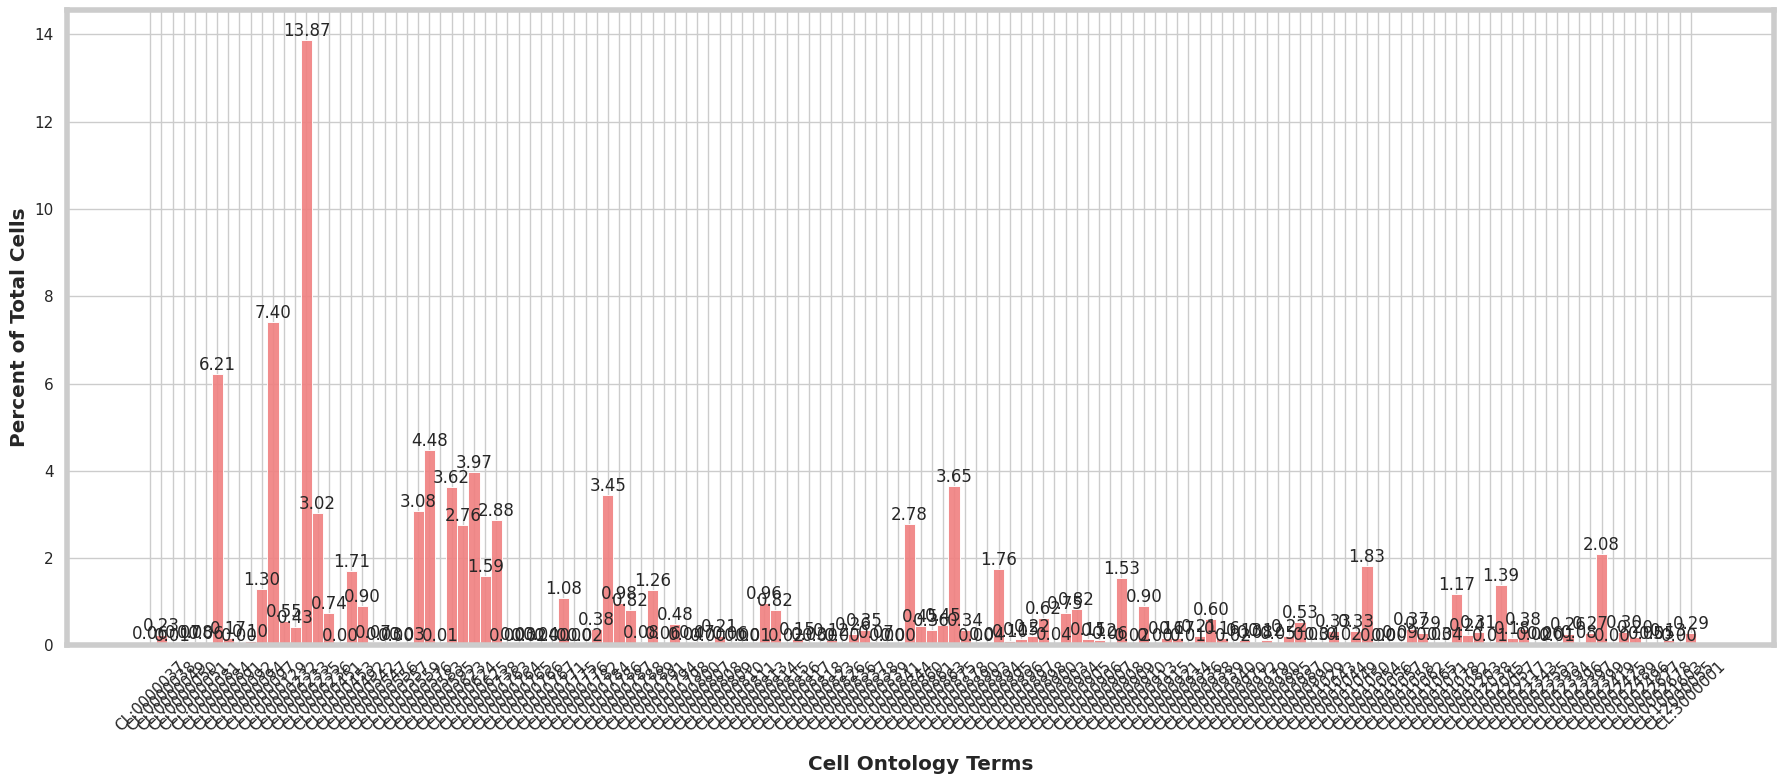

In [29]:
cell_ids = adata.obs['cell_type_ontology_term_id']

plt.figure(figsize=(18,8))

plots = sns.histplot(x=cell_ids,stat='percent',color='lightcoral',alpha=0.9)
# stat can also be probability or percent

plots.bar_label(plots.containers[0],fmt='%.2f')


#plt.xticks(rotation=90)
plt.xlabel('Cell Ontology Terms',labelpad=15)
plt.ylabel('Percent of Total Cells')
plt.xticks(rotation=45)


plt.show()

For the leucokyte dataset of 516,447 cells, the cell ID with the smallest percentage of data is CL:0001076, which makes up 0.00677 percent of the dataset. This corresponds to about 35 cells. The cell ID with the largest percentage is CL:0000895, which makes up 19.59 percent of the dataset. This corresponds to about 101,200 cells. 

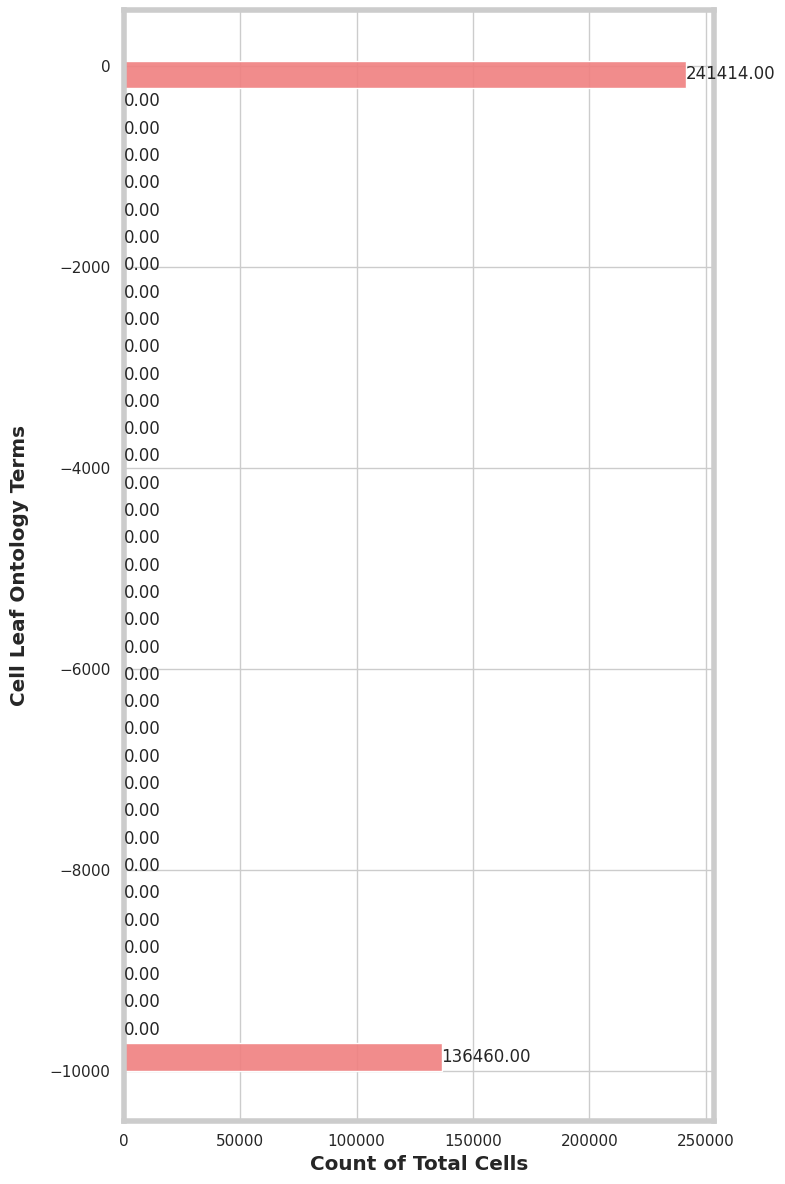

In [14]:
plt.figure(figsize=(8,12))


plots = sns.histplot(y=y_train.cpu(),stat='count',color='lightcoral',alpha=0.9)
# stat can also be probability or percent
plots.bar_label(plots.containers[0],fmt='%.2f')


#plt.xticks(rotation=90)
plt.ylabel('Cell Leaf Ontology Terms',labelpad=15)
plt.xlabel('Count of Total Cells')

plt.show()

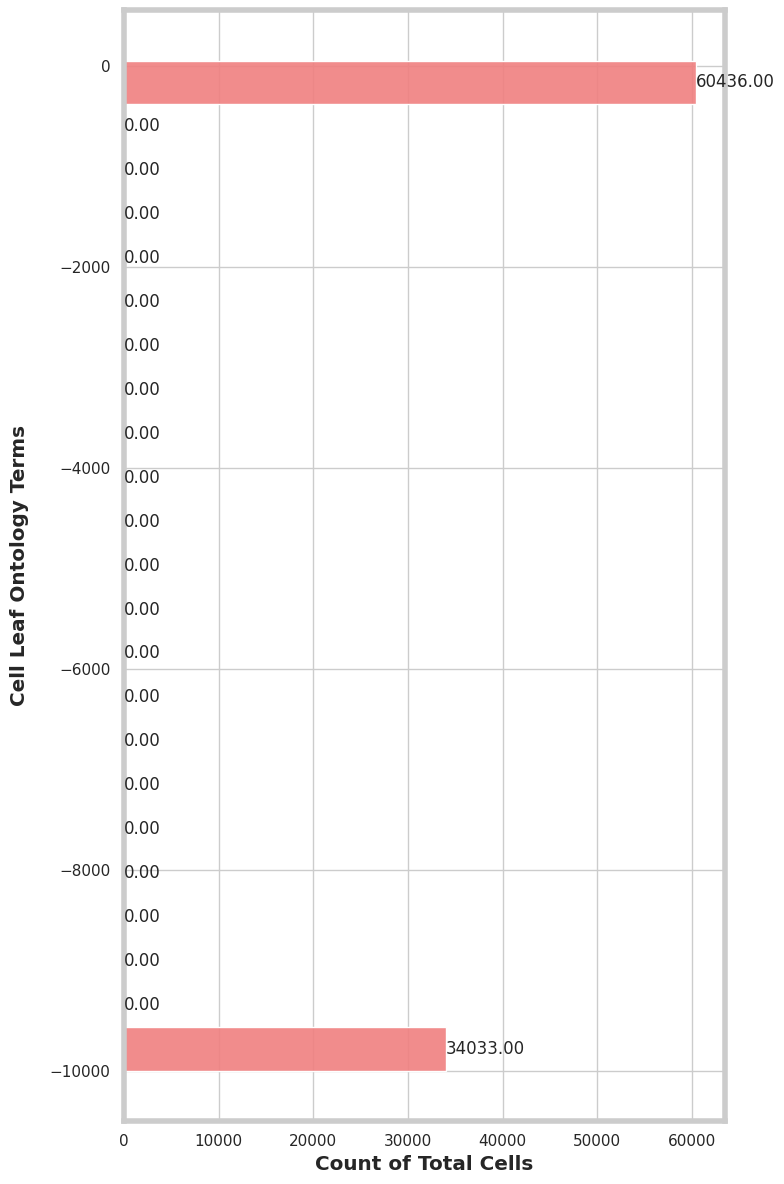

In [15]:
plt.figure(figsize=(8,12))


plots = sns.histplot(y=y_val.cpu(),stat='count',color='lightcoral',alpha=0.9)
# stat can also be probability or percent

plots.bar_label(plots.containers[0],fmt='%.2f')


#plt.xticks(rotation=90)
plt.ylabel('Cell Leaf Ontology Terms',labelpad=15)
plt.xlabel('Count of Total Cells')

plt.show()

In [16]:
y_val.unique(return_counts=True)

(tensor([-9999, -9998, -9997, -9996, -9995, -9994, -9993, -9992, -9991, -9990,
         -9989, -9988, -9987, -9986, -9985, -9984,     0,     1,     2,     3,
             4,     5,     6,     7,     8,     9,    10,    11,    12,    13,
            14,    15,    16,    17,    18,    19,    20,    21,    22,    23,
            24,    25,    26,    27,    28,    29,    30,    31,    32,    33,
            34,    35,    36,    37,    38,    39,    40,    41,    42,    43,
            44,    45,    46,    47,    48,    49,    50,    51]),
 tensor([  646,    88,  1017,  1045,    47,  1677,   567,   338,  1262,  9048,
         10283,   417,  1130,    16,   266,  6186, 21969,  2208,   132,   180,
            86,   357,   752,   162,   337,   320,   107,    53,   115,    83,
            26,    16,   183,    15,  1069,    39,     3,  5824,  1457,   148,
            24,    16,  3638,  1247,   799,   836,   578,   244,   229,     6,
           843,  2874,  1562,  1791,     3,   397,   889,    36,

In [25]:
#print(pd.DataFrame(y_train.cpu()).value_counts())

#print(pd.DataFrame(y_val.cpu()).value_counts())

difference_df = pd.Series(y_train.cpu()).value_counts(normalize=True) - pd.Series(y_val.cpu()).value_counts(normalize=True)



In [26]:
difference_df.head()

0    0.000160
1   -0.000525
2   -0.000051
3    0.000034
4   -0.000359
Name: proportion, dtype: float64

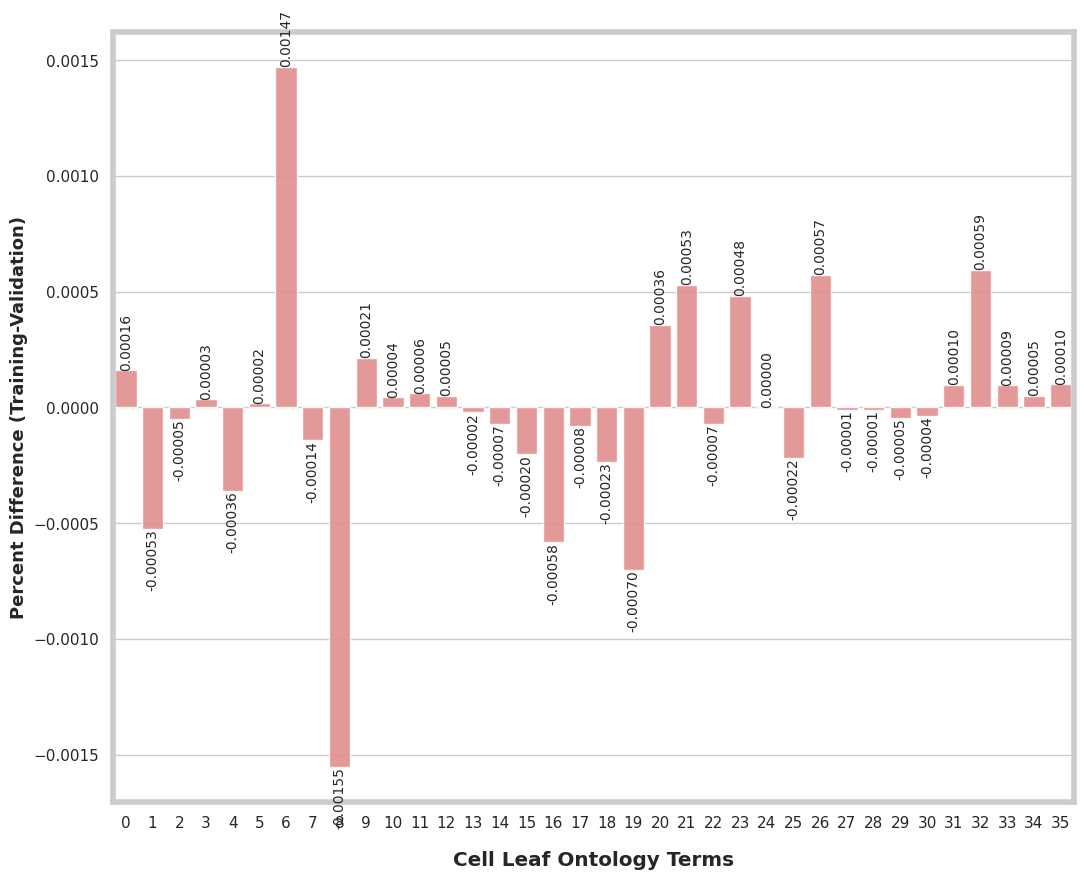

In [31]:
plt.figure(figsize=(11,9))


plots = sns.barplot(x=difference_df.index, y=difference_df.values,
            color='lightcoral',alpha=0.9)

plots.bar_label(plots.containers[0],fmt='%.5f',rotation=90,fontsize=10)

#plt.xticks(rotation=90)
plt.ylabel('Percent Difference (Training-Validation)', fontsize=13)
plt.xlabel('Cell Leaf Ontology Terms',labelpad=15)

plt.show()

## Data and Ontology Preprocessing

To prepare the data for modeling, we need to perform some preprocessing on the data and the ontology. We'll use three functions to make this happen. Full descriptions of these functions can be found in the functions. 

- find_parent: using the Cell Ontology (which should be opened and loaded as cl), finds the parents of cell types within specific distances

- get_tree: determines the tree structure for a particular cell type

- set_internal_node_relationships: determines the cell types to use for internal node calculations


- set_internal_node_values: build a dictionary to set which internal nodes are to be used in the loss calculation for internal nodes in the data

- build_parent_mask: builds a masking matrix to use for masking internal node loss values

- preprocess_data_ontology: this function encodes the AnnData object, splits apart the target values and primary data, and calculates some important variables from the Cell Ontology for later use 

- transform_data: transforms the data with log(1+x)

- split_format_data: splits the data into train and validation sets, and moves the variables to PyTorch tensors 


In [9]:
def preprocess_data(adata, target_column):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    #lb = LabelEncoder()
    #labels['encoded_labels'] = lb.fit_transform(labels[target_column])
    
    # we want to only encode the targets that are leafs. We will leave 
    # internal nodes as the CL number in order to assist with masking 
    # the appropriate parent nodes 
    # first, get list of all cell values
    all_cell_values = labels[target_column].unique().to_list()
    
    # identify which values are leafs
    # we use positive number for leaf values
    # and negative number for internal nodes
    mapping_dict = {}
    leaf_values = []
    internal_values = []
    encoded_leaf_val = 0
    encoded_internal_val = -9999
    for term in all_cell_values:
        if cl[term].is_leaf():
            mapping_dict[term] = encoded_leaf_val
            leaf_values.append(term)
            encoded_leaf_val += 1
        else:
            # check if internal values have associated sub-values in the dataset
            #    sub-values do not have to be leafs
            # if so, add value as internal values
            # if not, prune ontology so consider 
            term_subvalues = []
            # get leaf values of this term
            for sub_term in cl[term].subclasses(distance=None,with_self=False).to_set():
                    term_subvalues.append(sub_term.id)
            
            # get values in all_call_values in term_leafs
            intersection_list = list(set(all_cell_values).intersection(term_subvalues))
            if len(intersection_list) == 0:
                mapping_dict[term] = encoded_leaf_val
                leaf_values.append(term)
                encoded_leaf_val += 1
            else:
                mapping_dict[term] = encoded_internal_val
                internal_values.append(term)
                encoded_internal_val += 1            
            
            
    # use the leaf_mapping_dict to 
    labels['encoded_labels'] = labels[target_column].map(mapping_dict)
    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    return(x_data,y_data, mapping_dict, leaf_values, internal_values)

In [6]:
def find_parent(subclass, distance=1):
    '''
    Finds parent(s) of input subclass for current ontology, which must be loaded as cl. Parents will be 
    found within input distance of subclass. Immediate parents correspond with distance = 1. 
    
    Parameters
    ----------
    subclass : str
        string with full name of subclass you want to identify the parents of
        
    distance (optional): int
        distance from subclass you want to find parents of
        default = 1
        
    Returns
    -------
    parents : list
        list of parents for input subclass
    '''
    root_node = cl[subclass]
    parents = []
    for term in root_node.superclasses(distance=distance,with_self=False).to_set():
        parents.append(term.id)
    return parents

In [7]:
def get_tree(root,tree_dict,parents_or_children,level=0,top_parent = 'CL:0000000'):
    '''
    Determines tree structure starting with a leaf and identifying all superclasses/parents
    
    Parameters
    ----------
    root : str
        string with full name of ID you want to identify the parents of
        
    tree_dict : dictionary
        dictionary with tree. keys are levels, where level=0 is the initial leaf.
        values are ontology IDs
        
    level (optional): int
        level of root to build tree dictionary
        default = 0
        
    top_parent : string
        top level of ontology you wish you classify to. Used only if you want to return a subset
        of the ontology
        default = 'CL:0000000' (Cell in the Cell Ontology)
        
    Returns
    -------
    tree_dict : dictionary
        dictionary of tree given inital root. 
        keys are levels, where level=0 is the initial leaf.
        values are ontology IDs
        There will be duplicates in the keys because of multiple inheritance
        Can run list(set(key)) to remove duplicates
    '''


    # add root to dictionary if level = 0
    # need to check if level in tree_dict in case
    # we are iterating over multiple leafs
    if level == 0:
        if level in tree_dict:
            tree_dict[level].append(root)
        else:
            tree_dict[level] = [root]
    
    # get parent ids
    if parents_or_children == 'parents':
        parents_of_id = find_parent(root)
    elif parents_or_children == 'children':
        parents_of_id = find_children(root)
    level += 1
    
    # add parents to dictionary
    if level in tree_dict:
        tree_dict[level] += parents_of_id
    else:
        tree_dict[level] = parents_of_id

    if top_parent in parents_of_id: #parents_of_id is None:
        pass
    else:
        for parent in parents_of_id:
            tree_dict = get_tree(parent,tree_dict,parents_or_children=parents_or_children,level=level,top_parent = top_parent)
    
    return tree_dict


In [8]:
def set_internal_node_relationships_by_depth(internal_values,top_node,all_parent_nodes):
    '''
    Computes and returns a dictionary where each internal value is a key and the values are all Cell Ontology
    terms that are within the same distance from the top_node. Only returns values that are under top_node
    
    Relies upon get_tree and find_parents functions. 
    
    Assumes a CL object is already open. 
    
    Parameters
    ----------
    internal_values : list
        list of internal values that are included in the dataset
        
    top_node : string
        Cell Ontology Term ID that is the top of the tree to be considered
    
    all_parent_nodes : list
        from the dataset, a list of parent nodes in the ontology. Used to remove portions of
        the Ontology where we do not have child data
    
    Returns
    ----------
    parent_dict : dictionary
        keys are internal_values and values are all cell ontology terms within the same distance
        from the top node. 
    '''
    
    parents_or_children = 'parents'
    parent_dict = {}
    
    # loop through each value to calculate the values to include in parent_dict for that
    # internal value
    for internal_node in internal_values:

        # initialize the tree
        internal_tree = {}

        # use the get_tree function to get the tree structure from this node to the top
        tree_up = get_tree(internal_node,internal_tree,parents_or_children = parents_or_children,level=0,top_parent = top_node)
        # loop through the values, and return the key the corresponds to the first
        # instance of the top node
        # because of multiple inheritance, this value might be at different depths in the treee
        # we'll choose to be conservative and select the lowest depth value, which will appear
        # first in our tree.
        ###
        internal_node_depth_list = []
        for key,value_list in tree_up.items():
            if top_node in value_list:
                internal_node_depth_list.append(key)

        internal_node_depth = internal_node_depth_list[0]
        # take this distance, get all values within this distance of the top node

        internal_node_relatives = []

        # we don't want to include leaf terms, so we make sure it's not a leaf
        # HOWEVER, this doesn't account for internal nodes we treat as leaf terms
        # (because they have no children nodes in the dataset). to account for these
        # we have to double check with all_parent_nodes
        for term in cl[top_node].subclasses(distance=internal_node_depth,with_self=True).to_set():
            if not term.is_leaf():
                internal_node_relatives.append(term.id)

                
        # finally, check if values are in all_parent_nodes. only keep those that are
        # we are not including other 
        internal_node_relatives = [x for x in internal_node_relatives if x in all_parent_nodes]

        # update the dictionary for this internal node
        parent_dict[internal_node] = internal_node_relatives

    return(parent_dict)



In [7]:
def set_internal_node_values(internal_values,all_parent_nodes):
    '''
    Creates a dictionary where each key is an internal cell type and the values are the cell types
    we want to include when calculating the loss. We do not want to consider direct descendents of the
    internal cell type, so those are removed. 
    
    In other words, when calculating the loss for an internal node, we want to include all internal 
    nodes in the ontology EXCEPT those that are direct descendants of the target internal node. 
    
    Parameters
    ----------
    internal_values : list
        list of internal values that are included in the dataset
            
    all_parent_nodes : list
        from the dataset, a list of parent nodes in the ontology. Used to remove portions of
        the Ontology where we do not have child data
    
    Returns
    ----------
    parent_dict : dictionary
        keys are internal_values and values are all internal cell ontology terms EXCEPT descendents 
        of the internal value. The internal value is always included
    '''
    
    parent_dict = {}

    # loop through each value to calculate the values to include in parent_dict for that
    # internal value
    for internal_node in internal_values:
        # 1) get the children of this internal_node
        child_nodes = []
        for term in cl[internal_node].subclasses(distance=None,with_self=False).to_set():
            child_nodes.append(term.id)
        
        # 2) remove those values from all_parent_nodes
        cell_types_to_include = [x for x in all_parent_nodes if x not in child_nodes]
        
        # 3) create dictionary
        parent_dict[internal_node] = cell_types_to_include
    
    return(parent_dict)


In [8]:
def build_parent_mask(leaf_values,internal_values,ontology_df,parent_dict):
    '''
    Function to build a masking matrix for use when calculating the internal loss
    
    Uses parent_dict to denote, for internal cell types, which parents to include in the loss
    calculation. 
    
    Parameters
    -------
    leaf_values : list
        list composed of all leaf values included in the dataset
        includes internal nodes that do not have sub-values in the dataset, and thus are
        treated an leaf nodes

    internal_values : list
        list composed of interanal nodes in the dataset

    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    parent_dict : dictionary
        keys are internal_values and values are all internal cell ontology terms EXCEPT descendents 
        of the internal value. The internal value is always included
    
    Returns
    -------
    cell_parents_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation
    
    '''
    num_leafs = len(leaf_values)
    num_parents = ontology_df.shape[0]

    # internal_values are included as column values AND rows


    # for cell_parents_to_include, each column is a cell type included in the
    # dataset, so it is length = len(leaf_values) + len(internal_values)
    # the row values are the total number of parents included for the dataset 
    # for each internal value, we need to pick (1/0) if we include that parent
    # for the loss. For this, we reference parents_dict
    # WHAT is the order of the cell IDs for the rows???? This is important
    # This needs to match what we are already doing later, so let's go figure that out FIRST. 

    # for the leaf values, we want to include ALL parents in the 
    # loss calculation. So, we initialize the tensor as a ones tensor
    # based on the number of leaf values and the number of parents
    cell_parents_mask = torch.ones(num_parents,num_leafs)

    # now we can deal with the internal values. For these, we will not
    # include all parents. We will use parent_dict to select which to include


    # first, get a list of all the parents. The ordering of this list
    # is used later to propogate probabilities up the ontology.
    list_of_parents = ontology_df.index.tolist()

    # now, we need to loop through each internal value
    # internal_values is ordered as -9999 + n
    # this will be helpful later when we need to pull these values out. 
    # so the columns here are ordered at 0 to (number of leaf values), then -9999
    # to (number of internal values)

    for cell_id in internal_values:
        # get the list of parent cell IDs we want to include for this
        # particular internal_values
        parent_list_for_cell = parent_dict[cell_id]

        # loop through the parent_list_for cell, create a new binary list where
        # list is 1 if the parent is in the list_of_parents, otherwise 0
        parent_binary_list = [1 if parent in parent_list_for_cell else 0 for parent in list_of_parents]

        # convert the list to a tensor and reshape for concatenation
        parent_binary_tensor = torch.tensor(parent_binary_list).reshape(-1,1)

        # append to cell_parents_to_include. 
        # we append along columns
        cell_parents_mask = torch.cat((cell_parents_mask,parent_binary_tensor),1)

    return(cell_parents_mask)



In [9]:
def preprocess_data_ontology(adata, target_column,upper_limit = None, cl_only = False, include_leafs = False):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    This function also preprocesses the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Can have an upper limit to the ontology if upper_limit is set
    
    
    Assumes there is an active census object already open as cl. 

    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
     
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
        
    mapping_dict : Dictionary
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes

    leaf_values : list
        list composed of all leaf values included in the dataset
        includes internal nodes that do not have sub-values in the dataset, and thus are
        treated an leaf nodes

    internal_values : list
        list composed of interanal nodes in the dataset

    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    parent_dict : dictionary
        keys are internal_values and values are all cell ontology terms within the same distance
        from the top node. 
        
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation

    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    #lb = LabelEncoder()
    #labels['encoded_labels'] = lb.fit_transform(labels[target_column])
    
    # we want to only encode the targets that are leafs. We will leave 
    # internal nodes as the CL number in order to assist with masking 
    # the appropriate parent nodes 
    # first, get list of all cell values
    all_cell_values = labels[target_column].unique().to_list()
    
    # identify which values are leafs
    # we use positive number for leaf values
    # and negative number for internal nodes
    mapping_dict = {}
    leaf_values = []
    internal_values = []
    encoded_leaf_val = 0
    encoded_internal_val = -9999
    for term in all_cell_values:
        if cl[term].is_leaf():
            mapping_dict[term] = encoded_leaf_val
            leaf_values.append(term)
            encoded_leaf_val += 1
        else:
            # check if internal values have associated sub-values in the dataset
            #    sub-values do not have to be leafs
            # if so, add value as internal values
            # if not, prune ontology so consider 
            term_subvalues = []
            # get leaf values of this term
            for sub_term in cl[term].subclasses(distance=None,with_self=False).to_set():
                    term_subvalues.append(sub_term.id)
            
            # get values in all_call_values in term_leafs
            intersection_list = list(set(all_cell_values).intersection(term_subvalues))
            if len(intersection_list) == 0:
                mapping_dict[term] = encoded_leaf_val
                leaf_values.append(term)
                encoded_leaf_val += 1
            else:
                mapping_dict[term] = encoded_internal_val
                internal_values.append(term)
                encoded_internal_val += 1            
            
            
    # use the leaf_mapping_dict to 
    labels['encoded_labels'] = labels[target_column].map(mapping_dict)
    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    #########
    # now get a list of all parent nodes for each value in the dataset
    # if we want to include leafs, set with_self= True
    # else, set with_self = False
    
    all_parent_nodes = []
    for target in all_cell_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            all_parent_nodes.append(term.id)
            #if target == 'CL:0000904':
            #    print(term)
            
    # ensure that we do not have duplicate values
    all_parent_nodes = list(set(all_parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        all_parent_nodes = [x for x in all_parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)

        # remove these nodes from the parent_nodes list
        all_parent_nodes = [x for x in all_parent_nodes if x not in upper_limit_nodes]
        
    # create a dictionary that maps parents to reduce the ontology_df when
    # dealing with internal nodes
    #parent_dict = set_internal_node_relationships_by_depth(internal_values,upper_limit,all_parent_nodes)
    parent_dict = set_internal_node_values(internal_values,all_parent_nodes)
    
    # create the dataframe
    # use all_cell_values for the columns, because we need both leafs and
    # internals nodes for mapping
    ontology_df = pd.DataFrame(data=0, index = all_parent_nodes,
                                              columns = all_cell_values)
    
    # populate the dataframe with 1 if column is a sub-node 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]

    # create a dictionary that maps parents to reduce the ontology_df when
    # dealing with internal nodes
    #parent_dict = {}
    #for parent in internal_values:
    #    super_parent_list = []
    #    for term in cl[parent].superclasses(distance=None,with_self=True).to_set():
    #         if term.id in all_parent_nodes:
    #            super_parent_list.append(term.id)
    #    parent_dict[parent] = super_parent_list

    # build a matrix used to mask parent values
    cell_parent_mask = build_parent_mask(leaf_values,internal_values,ontology_df,parent_dict)
    
    return(x_data,y_data, mapping_dict, leaf_values, internal_values, ontology_df, parent_dict, cell_parent_mask)




Term CL:0000766

OLD: ['CL:0000738', 'CL:0000766','CL:0000255',  'CL:0002242','CL:0000763',  'CL:0000988',  'CL:0000219']

NEW: ['CL:0000988','CL:0000232','CL:0000738',  'CL:0000766', 'CL:0000764',  'CL:0000763',  'CL:0000837',  'CL:0000094','CL:0008001',  'CL:0000842',  'CL:1001610',  'CL:0000081','CL:0002032',  'CL:0000145',  'CL:0002031']


Old way has 7 terms
New way has 15 terms

Some terms in old are NOT in new: CL:0000255, CL:0002242, CL:0000219. These values are all above 766, but NOT under Hematopoetic cell. This is good, as we don't want to include periphery data

this is because I use subclasses in the internal calculation, so I start with Hematopoeitc and go down from there. This makes sense, huzzah


In [10]:
def transform_data(x_data):
    '''
    This function takes the input x_data, transforms the data with log(1+x) and 
    returns the transformed data
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    '''
    
    # np.log takes the natural log
    x_data.data = np.log(1+ x_data.data)

    return x_data


In [11]:
def split_format_data(x_data, y_data, train_size, val_size, holdout_size = None, random_state = None):
    '''
    This function splits x_data and y_data into training and validation sets, then formats the data into
    tensors for modeling with PyTorch
    
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    y_data : Series
        Pandas series of encoded target values
        
    train_size: float
        float between 0.0 and 1.0 to select the training fraction of the data set
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    '''
    
    
    if holdout_size:
        # split into training and validation sets
        # first split into train and validation/holdout
        X_train, X_val_holdout, y_train, y_val_holdout = train_test_split(x_data,y_data,
                                                       train_size = train_size,
                                                         random_state=random_state)

        # calculate the validation split of the remainder 
        val_split_size = val_size / (val_size + holdout_size)

        # split the validation/holdout set to separate sets
        X_val, X_holdout, y_val, y_holdout = train_test_split(X_val_holdout, y_val_holdout,
                                                             train_size = val_split_size,
                                                             random_state=random_state)
    else:
        # split into training and validation sets
        # first split into train and validation/holdout
        X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                       train_size = train_size,
                                                         random_state=random_state)

    
    # check if number of genes in X_train = X_val
    # rarely, splitting the dataset can cause a difference
    # if it does, resplit the data by looping back into this function

    if holdout_size:
        if (X_train.shape[1] != X_val.shape[1]) or (X_train.shape[1] != X_holdout.shape[1]):
            X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state = None)
        else:
            print('Success. Number of genes in datasets match.')
    else:
        if (X_train.shape[1] != X_val.shape[1]):
            X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_format_data(x_data, y_data, train_size, val_size, holdout_size, random_state = None)
        else:
            print('Success. Number of genes in datasets match.')


    
    # convert the data to tensors
    # we'll change the data from CSR (compressed sparse row) format
    # to COO (coordinate) format for better use with pytorch
    # see https://pytorch.org/docs/stable/sparse.html for additional details
    # conversion from COO to tensor based on https://stackoverflow.com/questions/50665141/converting-a-scipy-coo-matrix-to-pytorch-sparse-tensor

    # copy the X matrix to save in scipy CSR format
    x_train_csr = X_train.copy()
    

    X_train_coo = X_train.tocoo()
    #X_train = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_train_coo.row,X_train_coo.col))),
    #                              torch.FloatTensor(X_train_coo.data))

    X_train_values = X_train_coo.data
    X_train_indices = np.vstack((X_train_coo.row, X_train_coo.col))

    X_train_i = torch.LongTensor(X_train_indices)
    X_train_v = torch.FloatTensor(X_train_values)
    X_train_shape = X_train_coo.shape

    X_train = torch.sparse.FloatTensor(X_train_i, X_train_v, torch.Size(X_train_shape))  
    
    
    # y_train is a Series, so it is easier to convert to a tensor
    y_train = torch.tensor(y_train,device=device)#, dtype=torch.long)

    # and the same for the validation set
    X_val_coo = X_val.tocoo()
    #X_val = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_val_coo.row,X_val_coo.col))),
    #                                  torch.FloatTensor(X_val_coo.data))

    
    X_val_values = X_val_coo.data
    X_val_indices = np.vstack((X_val_coo.row, X_val_coo.col))

    X_val_i = torch.LongTensor(X_val_indices)
    X_val_v = torch.FloatTensor(X_val_values)
    X_val_shape = X_val_coo.shape

    X_val = torch.sparse.FloatTensor(X_val_i, X_val_v, torch.Size(X_val_shape)).to(device)  
    
    
    # y_val is a Series, so it is easier to convert to a tensor
    y_val = torch.tensor(y_val,device=device)#, dtype=torch.long)

    if holdout_size:
        #pass
        # and the same for the holdout set
        X_holdout_coo = X_holdout.tocoo()
        #X_holdout = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_holdout_coo.row,X_holdout_coo.col))),
        #                              torch.FloatTensor(X_holdout_coo.data))

        X_holdout_values = X_holdout_coo.data
        X_holdout_indices = np.vstack((X_holdout_coo.row, X_holdout_coo.col))

        X_holdout_i = torch.LongTensor(X_holdout_indices)
        X_holdout_v = torch.FloatTensor(X_holdout_values)
        X_holdout_shape = X_holdout_coo.shape

        X_holdout = torch.sparse.FloatTensor(X_holdout_i, X_holdout_v, torch.Size(X_holdout_shape)).to(device)   

        
        # y_holdout is a Series, so it is easier to convert to a tensor
        y_holdout = torch.tensor(y_holdout, dtype=torch.long,device=device)
    
    
    if device.type == "cuda":
        print('y_train, X_val, y_val moved to GPU. X_train not moved to GPU. ')
            
    if holdout_size:
        return(X_train, X_val, y_train, y_val, X_holdout, y_holdout, x_train_csr)
    else:
        return(X_train, X_val, y_train, y_val,x_train_csr)

In [11]:
def preprocess_ontology(adata,target_column,upper_limit = None, include_leafs = False, cl_only = False, only_leafs_for_targets=False):
    '''
    This function processes the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Can have an upper limit to the ontology if upper_limit is set
    
    
    Assumes there is an active census object already open as cl. 
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    only_leafs_for_targets : boolean
        option to specify that targets are already known to include leafs
        Default: False - program will check all targets and find any additional leafs
                True means that list of unique values in the target column will be used

        
    Returns
    -------
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    parent_dict : dictionary
        dictionary where values are lists of Cell Ontology term IDs that are the parents (inclusive) 
        for the Cell Ontology Term ID key.
        
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # select the unique target values
    target_values = labels[target_column].unique()
    
    # check that these are leaf nodes
    # if not, find the leaf under that value
    
    if only_leafs_for_targets:
        leaf_nodes = target_values
    else:
        leaf_nodes = []
        for target in target_values:
            if cl[target].is_leaf():
                leaf_nodes.append(target)
            else:
                for term in cl[target].subclasses(distance=None,with_self=False).to_set():
                    if term.is_leaf():
                        leaf_nodes.append(term.id)
    
    # ensure that we do not have duplicate values
    leaf_nodes = list(set(leaf_nodes))
    
    
    # now get all parent nodes
    # if we want to include leafs, set with_self = True
    # else, set with_self = False
    parent_nodes = []
    for target in target_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            parent_nodes.append(term.id)
            
    # ensure that we do not have duplicate values
    parent_nodes = list(set(parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        parent_nodes = [x for x in parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)
            
        # remove these nodes from the parent_nodes list
        parent_nodes = [x for x in parent_nodes if x not in upper_limit_nodes]
        
    
    # create the dataframe
    ontology_df = pd.DataFrame(data=0, index = parent_nodes,
                                              columns = leaf_nodes)


    # populate the dataframe with 1 if column leaf is a leaf 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]
                    
    # create a dictionary that maps parents to reduce the ontology_df when
    # dealing with internal nodes
    parent_dict = {}
    for parent in parent_nodes:
        super_parent_list = []
        for term in cl[parent].superclasses(distance=None,with_self=True).to_set():
            if term.id in parent_nodes:
                super_parent_list.append(term.id)
        parent_dict[parent] = super_parent_list
        
        
    return(ontology_df, parent_dict)

## Main Loop For Preprocessing Data

In [12]:

target_column = 'cell_type_ontology_term_id'

upper_limit = 'CL:0000988' # leukocyte = 738, hematopoietic = 988

print('start preprocess data and ontology')
x_data,y_data, mapping_dict, leaf_values,internal_values, \
    ontology_df, parent_dict, cell_parent_mask =  preprocess_data_ontology(adata, target_column,
                                                                           upper_limit = upper_limit, 
                                                                 cl_only = True, include_leafs = False)

###del adata

# create dataframe that only includes leaf nodes
ontology_leaf_df = ontology_df[leaf_values]

print('start transforming data')
x_data = transform_data(x_data)


train_size = 0.8
val_size = 0.2
holdout_size =  None # None if you don't want holdout set
random_state = 42

print('start split and format data')
if holdout_size:
    X_train, X_val, y_train, y_val, \
    X_holdout, y_holdout, x_train_csr = split_format_data(x_data, y_data, train_size, val_size, 
                                                          holdout_size, random_state=random_state)
else:
    X_train, X_val, y_train, y_val, \
    x_train_csr = split_format_data(x_data, y_data, train_size, val_size, 
                                    holdout_size, random_state=random_state)

print('Preprocessing complete. There are {0} leaf values and {1} internal values.'.format(len(leaf_values),len(internal_values)
                                                                                         ))
print('There are {0} cells in the training set and {1} cells in the validation set, both contain {2} genes.'.format(X_train.shape[0],X_val.shape[0],X_train.shape[1]))


start preprocess data and ontology
start transforming data
start split and format data
Success. Number of genes in datasets match.
Preprocessing complete. There are 52 leaf values and 16 internal values.
There are 377874 cells in the training set and 94469 cells in the validation set, both contain 19966 genes.


In [76]:
#cell_parent_mask.shape
len(parent_dict['CL:0000766']) #9996

80

In [78]:
len(parent_dict['CL:0000791']) #9995

78

In [14]:
# save the x_data scipy sparse matrix
sparse.save_npz('x_data_5Dec.npz',x_data)

# to load:
# x_data = sparse.load_npz('x_data_5Dec.npz')

In [14]:
len(leaf_values)

52

In [16]:
len(internal_values)

16

In [18]:
#y_train
y_val[y_val < 0].shape#unique(return_counts=True)

torch.Size([34033])

241414 + 60436 leaf cells = 64%
136460 + 34033 
472312




In [19]:
# save information needed for testing external models 
# this included the ontology dfs, mapping dict, leaf_values, internal_values

os.chdir('/home/fujoshua/cell_classification')
ontology_df.to_csv('ontology_df_1Dec.csv')
ontology_leaf_df.to_csv('ontology_leaf_df_1Dec.csv')

mapping_dict_df = pd.DataFrame.from_dict(mapping_dict,orient='index')
mapping_dict_df.to_csv('mapping_dict_df_1Dec.csv')


with open("leaf_values_1Dec", "wb") as fp:   #Pickling
    pickle.dump(leaf_values, fp)
    
with open("internal_values_1Dec", "wb") as fp:   #Pickling
    pickle.dump(internal_values, fp)



In [21]:
ontology_df

,CL:0002678,CL:0000789,CL:0000800,CL:0002489,CL:0000556,CL:0000051,CL:0001057,CL:0002117,CL:0000765,CL:0000092,...,CL:0002038,CL:0000810,CL:1001603,CL:0000771,CL:0000557,CL:0000938,CL:0001203,CL:0000844,CL:0000837,CL:0000817
CL:0002032,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CL:0000234,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CL:0000473,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CL:0000897,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CL:0000219,1,1,1,1,0,0,1,1,0,1,...,1,1,1,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CL:0001012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CL:0000623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CL:0000909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CL:0000837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
# save validation data

torch.save(X_val, 'X_val_17Nov.pt')
torch.save(y_val,'y_val_17Nov.pt')

In [21]:
#print(X_train.is_cpu)
#print(X_val.is_cuda())
#print(y_train.get_device())
#print(y_val.is_cuda())
type(X_train)

print('X_train size in MB: ', X_train.element_size() * X_train.nelement() * 10e-6)

print('X_val size in MB: ', X_val.element_size() * X_val.nelement() * 10e-6)

print('y_train size in MB: ', y_train.element_size() * y_train.nelement() * 10e-6)

print('y_val size in MB: ', y_val.element_size() * y_val.nelement() * 10e-6)


X_train size in MB:  329236.55016000004
X_val size in MB:  82309.73520000001
y_train size in MB:  33.05256
y_val size in MB:  8.263200000000001


In [13]:
# check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1

print(X_train.get_device())
print(X_val.get_device())
print(y_train.get_device())
print(y_val.get_device())


-1
0
0
0


In [21]:
print(X_train.shape)
print(y_train.shape)


print(X_val.shape)
print(y_val.shape)

#print(X_holdout.shape)
#print(y_holdout.shape)


torch.Size([1964092, 19966])
torch.Size([1964092])
torch.Size([491023, 19966])
torch.Size([491023])


## Build Neural Network Classifier

First, we need to select and define the input and output dimensions from the data. The number of neurons for the hidden nodes is defined manually.

In [13]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of neurons for hidden layers
hidden_layer_1 = 256
hidden_layer_2 = 128

# number of classes (unique of y)
output_dim = torch.unique(y_train[y_train >= 0]).size(dim=0) #labels['encoded_labels'].nunique()

print(input_dim,hidden_layer_1,hidden_layer_2,output_dim)

19966 256 128 52


In [14]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.linear3 = nn.Linear(hidden_layer_2,output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x,dim=1)
        return x
    
    def get_last_layer(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

## Functions for dealing with cell ontology and loss calculations

We'll need a few specific functions to process the predicted values with the structure of the Cell Ontology. We'll define these here. Full details of each function are found in each space. 

- output_probability_tensor: convolves the predicted classification outputs with the ontology hierarchy to get predicted normalized probabilities for all parent nodes
- target_probability_tensor: convolves the known target values with the ontology hierarchy to get target probabilities for all parent nodes
- internal_target_probability_tensor: same as target_probability_tensor, but some small changes for dealing with internal nodes
- internal_node_loss: calculates the loss (and other values) for internal nodes

In [15]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convolve the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    
    # if there is only a single column for the ontology, change shape to match expected value
    if len(ontology_tensor.shape) == 1:
        ontology_tensor = ontology_tensor.unsqueeze(1)    
    #print(ontology_tensor.shape)
    #print(outputs.shape)
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    
    ##sum_masked_probability_tensor = sum_probability_tensor * batch_masking_tensor
    #print('sum masked',sum_masked_probability_tensor.shape)
    #print('sum masked',sum_masked_probability_tensor.sum(dim=1))
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    ##sum_masked_probability_tensor = torch.where(sum_masked_probability_tensor > 1, 1.0, sum_masked_probability_tensor )
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )

    return sum_probability_tensor


In [16]:
def build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value):
    '''
    For each batch, this function builds the correct masking tensor based on which
    values of the cell ontology we want to include given the target. It returns aa 
    
    Parameters
    ----------
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation
                
    y_batch : tensor
        tensor with encoded target values for current batch of data
        
    min_encoded_value : int
        the minimum encoded value from the full set of target values. Typically -9999
        
    max_encoded_value : int
        the maximum encoded value from the full set of target values. Depends on number
        of leaf targets in the dataset

    Outputs
    -------
    batch_masking_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Binary tensor to zero out probabilities we do not want
    
    '''
    # 1) from y_batch, we need to get the indices we'll use to select from cell_parent_mask
    #.   all the positive values are each, but we need to convert the negative values to
    #.   correspond with the (positive) index they would otherwise be. Then save to a tensor
    
    for value in y_batch:
        if value >= 0:
            new_value = value
        else:
            new_value = (value - min_encoded_value) + max_encoded_value + 1
        try:
            converted_y_batch = torch.cat((converted_y_batch,new_value.reshape(1)),dim=0)
        except:
            converted_y_batch = new_value.reshape(1)
    
    
    # 2) use the y_batch converted values to build a new tensor from cell_parent_mask
    #.    that is the mask we will use for this batch of values.
    #.    return this tensor

    cell_parent_mask = cell_parent_mask.to(device)
    batch_masking_tensor = torch.index_select(cell_parent_mask,1,converted_y_batch)
    #print(batch_masking_tensor.sum(dim=0))
    
    return(batch_masking_tensor)

    


In [17]:
def target_probability_tensor(target_values,ontology_df,mapping_dict):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node

    mapping_dict : dictionary
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes

    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    
    # invert the mapping dict so that we can select columns by CELL TYPE ID
    inv_mapping_dict = {v: k for k,v in mapping_dict.items()}

    for count, target_value in enumerate(target_values):
        # get the cell ID from the inverted mapping dictionary based on the encoded value
        target_cell_id = inv_mapping_dict[target_value.item()]
        
        # look up the correct column by the Cell ID. get those column values and convert
        # to a tensor
        sub_target_tensor = torch.tensor(ontology_df.loc[:,target_cell_id].values,dtype=float).reshape(-1,1)
        
        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    #print('target tensor shape',target_tensor.shape)
    #print('batch_masking_tensor',batch_masking_tensor.shape)
    ###masked_target_tensor = target_tensor * batch_masking_tensor
    ##print('masked target tensor',masked_target_tensor.shape)
    
    target_tensor = target_tensor.to(device)
    ###masked_target_tensor = masked_target_tensor.to(device)
    
    
    return target_tensor

In [17]:
def internal_target_probability_tensor(target_values,ontology_df):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation. Very similar to target_probability_tensor, but
    specific for dealing with internal node classifications only
    
    All cells are of the same type
    
    Parameters
    ----------    
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and column is single cell ID
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.DoubleTensor(ontology_df.values).unsqueeze(1) 
    ontology_tensor = ontology_tensor.to(device)
            
    # if there is only a single column for the ontology, change shape to match expected value
    #if len(ontology_tensor.shape) == 1:
    #    ontology_tensor = ontology_tensor.unsqueeze(1)    

    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    for count, target_value in enumerate(target_values):
        if count == 0 :
            target_tensor = ontology_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,ontology_tensor),1).requires_grad_()
    target_tensor = target_tensor.to(device)
    return target_tensor

In [18]:
def internal_node_loss(output_internal,y_batch_internal,internal_values,mapping_dict,ontology_df,ontology_leaf_df,criterion_parents,threshold):
    '''
    Calculate the loss for cells whose target values are internal nodes. This function loops through each
    internal nodes value listed in internal_values, selects the predicted and target values for that
    cell, calculates the loss for the cell, then calculates the mean loss for all internal nodes
    
    Parameters
    ----------
    output_internal : Tensor
        pytorch tensor of output values from the classifier for all internal nodes
        
    y_batch_internal : Tensor
        pytorch tensor of target values for all internal nodes
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
        
    ontology_df : DataFrame
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    ontology_leaf_df : DataFrame
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.

    criterion_parents : loss function
        pytorch loss function used to calculate the loss for the internal nodes
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction. Only used for
        the accuracy calculation. 

    Returns
    -------    
    mean_internal_node_loss : tensor
        pytorch single-value tensor with the mean loss for all internal 
        nodes in the dataset
        
    total_accuracy_cell : tensor
        record of the accuracy for each internal cell type
    
    total_number_of_cells : tensor
        the total number of cells for each different internal node
        used later for weighting functions by this number
    '''
    # we will store the losses in a list, then calculate the mean 
    # at the end
    stored_losses = []
    
    # we need to get a list of the internal values in this batch of data
    encoded_values_batch = y_batch_internal.unique().tolist()
    #print(encoded_values_batch)
    internal_values_batch = []
    for x in encoded_values_batch:
        internal_values_batch.append(next(key for key, value in mapping_dict.items() if value == x))
    
    for internal_cell in internal_values_batch:
        # get the encoded value for this cell
        map_value = mapping_dict[internal_cell]
        #print(internal_cell)
        
        # use the encoded value to select the predicted and known values 
        # for that cell
        output_cell_internal = output_internal[y_batch_internal == map_value]
        y_cell_internal = y_batch_internal[y_batch_internal == map_value]
        
        # use output_probability_tensor to sum the predicted probabilities
        # up the whole ontology,
        output_parent_prob_all = output_probability_tensor(output_cell_internal,ontology_leaf_df)
        # select the rows that are relevant for this internal node
        
        ################
        # need to change the following 5 rows to keep values for a wider
        # range of the ontology
        # tentative plan: 
        # 1) use parent_dict to select values we want to keep
        # 2) select the rows from ontology_leaf_df that match values in parent_dict
        # 3) filter output_parent_prob_all to only those values
        #print(output_parent_prob_all.shape)
        internal_rows_list = parent_dict[internal_cell] #1
        #print(internal_rows_list)
        internal_indices = [ontology_leaf_df.index.get_loc(row) for row  in internal_rows_list] #2
        #print(internal_indices)
        #print(ontology_leaf_df.index)
        output_parent_prob_all_internal = output_parent_prob_all[internal_indices] #3
        #print(output_parent_prob_all_internal.shape)
        #print(output_parent_prob_all_internal)
                
        
        # this next part is an old way of doing it can and probably be deleted ####
        # For this cell, select the column of the ontology_df
        # this let's us know the parents of the target value
        # pick the correct column, then get the values (0 or 1) into a Tensor
        ontology_internal_cell_df = ontology_df[internal_cell]
        ####ontology_internal_cell_values = torch.FloatTensor(ontology_internal_cell_df.values)
        ####ontology_internal_cell_values = ontology_internal_cell_values.to(device)

        # multiple the ontology_internal_cell_values by the predictions to zero out the values
        # that don't apply for this cell. All predictions that apply with stay with the
        # predicted probability. 
        ####output_parent_prob_all_internal = ontology_internal_cell_values[:,None] * output_parent_prob_all         

        # remove the rows/values that are zeros
        ####output_parent_prob_all_internal = output_parent_prob_all_internal[output_parent_prob_all_internal.sum(dim=1) != 0]

        # Now, to get the known probabilities, we need to identify the values that are parents,
        # then select and pick the relevant rows of the ontology df
        #print('internal_rows_list (parent dict[internal cell])',internal_rows_list)
        parent_indices = [ontology_internal_cell_df.index.get_loc(row) for row  in internal_rows_list]
        #print('parent_indices',parent_indices)
        ontology_internal_cell_df_sc = ontology_internal_cell_df[parent_indices]

        # now we can calculate the probability tensors for the
        #  known values
        ###output_parent_prob = output_probability_tensor(output_cell_internal,ontology_internal_cell_df)
        target_parent_prob = internal_target_probability_tensor(y_cell_internal,ontology_internal_cell_df_sc)

        #print('output_parent_prob_all_internal',output_parent_prob_all_internal.shape)
        #print('target_parent_prob',target_parent_prob.shape)
        
        # and then we calculate the BCE loss and store the value for this cell
        cell_loss = criterion_parents(output_parent_prob_all_internal,target_parent_prob)
        stored_losses.append(cell_loss.item())
        
        # we need to calculate the accuracy here because the number of
        # cells and internal parent nodes will vary for each internal cell
        # we will track the amount of data so we can weight appropriately 
        # when combining
                
        # calculate the accuracy
        # use the threshold value to convert input into predicted labels
        accuracy_cell =  multilabel_accuracy(output_parent_prob_all_internal,target_parent_prob,
                                            threshold=threshold,criteria='hamming')

        # save the number of cells for this node, for use in weighting when
        # determining the overall accuracy
        number_of_cells = output_parent_prob_all_internal.shape[1]
        
        # save the accuracy and number of cell values
        if internal_cell == internal_values_batch[0]:
            # if this is the first loop, initialize
            # the tensors we'll save
            total_accuracy_cell = accuracy_cell.reshape(1)
            total_number_of_cells = torch.tensor(number_of_cells).reshape(1)
        else:
            # append tensors for saving
            total_accuracy_cell = torch.cat((total_accuracy_cell,accuracy_cell.reshape(1)),0)
            total_number_of_cells = torch.cat((total_number_of_cells,torch.tensor(number_of_cells).reshape(1)),0)
            
    
    # take the mean of the loss values for each cell ID
    # this gives us the mean loss for all internal nodes
    mean_internal_node_loss = torch.tensor(np.mean(stored_losses))
    
    # move total number of cells to GPU, if available
    # total accuracy cell is already on GPU, if available
    total_number_of_cells = total_number_of_cells.to(device)
    
        
    return mean_internal_node_loss, total_accuracy_cell, total_number_of_cells
       

# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Important Details:
- we use mini-batch learning, with the batch size set by the user
- we model each batch of data at once, then split into leaf and internal nodes, based on the values in y_batch
- we calculate the 3 loss three different ways, then sum to get the total loss
- we calculate and save the loss, accuracy, and F1 score for metrics to review



## Marginalization with Manual Batches

In [18]:
def marginalization_classification_manual_batch(X_train,X_val,y_train,y_val,num_epochs,ontology_leaf_df, 
                                                batch_size,internal_values,mapping_dict,
                                               ontology_df, threshold, cell_parent_mask):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_leaf_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    
    batch_size : int
        integer specificying the number of samples processed before the model
        is updated
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
    
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are leafs and internal nodes in portion of ontology being 
        queried. 
        Differs from ontology_leaf_df in that columns include both leaf and internal node values
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction
        
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation

        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_leaf_hist : list
            list containing accuracy for leaf values for the training set per epoch
            
        accuracy_train_internal_hist : list
            list containing accuracy for internal values for the trainig set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        loss_train_internal_hist : list
            list containing loss values for internal nodes for the training set per epoch
        
        accuracy_val_leaf_hist : list 
            list containing accuracy for leaf values for the validation set per epoch
        
        accuracy_val_internal_hist : list
            list containing accuracy for internal values for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        loss_val_internal_hist : list
            list containing loss values for internal nodes for the validation set per epoch
        
        f1_score_train_leaf : list
            list containing Macro F1 score for leaf nodes for training set per epoch 
        
        f1_score_val_leaf : list
            list containing Macro F1 score for leaf nodes for validation set per epoch 
        
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch
            
        best_state_dict : dictionary
            Pytorch state_dict that contains the parameters for the best fitting models
    '''
    # initialize variables for saving values
    accuracy_train_leaf_hist = []
    accuracy_train_internal_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_internal_hist = []
    loss_train_hist = []
    
    accuracy_val_leaf_hist = []
    accuracy_val_internal_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []
    loss_val_internal_hist = []
    
    f1_score_train_leaf = []
    f1_score_val_leaf = []
    
    f1_score_train_parent = []
    f1_score_val_parent = []

    best_accuracy = - np.inf
    best_weights = None
    
    # get the list of leaf labels
    leaf_label_list = [value for (key,value) in mapping_dict.items() if value >= 0]

    # get the min and max encoded values
    min_encoded_value = min(y_train).item()
    max_encoded_value = max(y_train).item()

    # initialize network
    clf = Network()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize the leaf loss here
    # because of how we weight the parent loss, we will have to initialize that
    # loss on each iteration because the weighting will change.
    criterion_leafs = nn.CrossEntropyLoss(reduction='mean')
    
    #criterion_parents = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)#, amsgrad=True, eps=1e-5)
    #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)

    #start_epoch = time.time()
    for epoch in range(num_epochs):
        #print('on epoch', epoch)
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        
        running_train_loss = 0.0
        #correct_train = 0
        #y_length = 0
                
        # set up manual batches - from https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
        permutation = torch.randperm(X_train.size()[0]).to(device)
        permutation_cpu = permutation.cpu() # we want the same permutations, but need one copy on the cpu

        #start = time.time()
        for i in range(0,X_train.size()[0], batch_size):
            #if (i/batch_size) % 10 == 0:
            #print('on batch', i/batch_size, 'running time', (time.time()-start))

            indices = permutation[i:i+batch_size]
            indices_cpu = permutation_cpu[i:i+batch_size]
            #X_batch, y_batch = X_train[indices], y_train[indices] # doesn't work for sparse tensors

            X_batch = torch.index_select(X_train,0,indices_cpu).to(device)

            y_batch = torch.index_select(y_train,0,indices)#.to(device)

            
            # check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1
            #print(X_batch.get_device())
            #print(y_batch.get_device())
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            #if epoch == 0:
            #    outputs_train = clf_nosoftmax(X_batch.float()) # might need to change to X_train.float()
            #else:
            outputs_train = clf(X_batch.float()) # might need to change to X_train.float()
            
            ######
            # create mask to separate leaf and internal nodes
            ######
            output_train_leaf = outputs_train[y_batch >= 0]
            #print(output_train_leaf.shape)
            y_batch_leaf = y_batch[y_batch >= 0]
            #print(y_batch_leaf.shape)
            
            #output_train_internal = outputs_train[y_batch < 0]
            #y_batch_internal = y_batch[y_batch < 0]
            

            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(output_train_leaf, y_batch_leaf)

            # get the masking tensor for this batch of cells
            # for calculating the internal loss
            # we initialize BCE loss every batch because the mask changes based on which cells are
            # included and ordered for this batch
            batch_train_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value)
            criterion_parents = nn.BCELoss(weight=batch_train_masking_tensor,reduction='mean')

            
            # calculate the loss for the parents of the cells that are leafs
            output_train_parent_prob = output_probability_tensor(outputs_train,ontology_leaf_df)
            target_train_parent_prob = target_probability_tensor(y_batch,ontology_df,mapping_dict)

            #print(output_train_parent_prob)
            #print('output_train_parent_prob',output_train_parent_prob.shape)
            #print(target_train_parent_prob)
            #print('target_train_parent_prob',target_train_parent_prob.shape)
            
            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            #######
            # calculate the loss for the cells that are internal nodes
            ##### total_accuracy_cell, total_number_of_cells
            
            #loss_train_internal, batch_accuracy_internal, batch_numbers_internal = internal_node_loss(
            #                                        output_train_internal,y_batch_internal,
            #                                         internal_values,mapping_dict,ontology_df,
            #                                        ontology_leaf_df,criterion_parents,threshold)
            
            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents #+ loss_train_internal

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
             
            running_train_loss += loss_train.item()
           
            # save predictions
            _, train_leaf_pred_per_epoch = output_train_leaf.max(dim=1)

            # calculate accuracy for internal cells
            #####
            # need to update this with the weighting somehow!!!!
            #####
            train_batch_accuracy = multilabel_accuracy(output_train_parent_prob,target_train_parent_prob,
                                                      threshold=threshold,criteria='hamming')
            
            # save the number of cells for batch, for use in weighting when
            # determining the overall accuracy per epoch
            train_batch_number_of_cells = output_train_parent_prob.shape[1]
                        
            # check size of internal tensors. if only 1 internal cell
            # reshape and detach
            # else just detach
            
            ##if len(batch_accuracy_internal.size()) == 0:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach().reshape(1)
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach().reshape(1)
            ##else:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach()
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach()
                
            
            if i == 0:
                train_leaf_pred_total = train_leaf_pred_per_epoch.detach()
                y_train_leaf_total = y_batch_leaf.detach()
                train_batch_accuracy_internal = train_batch_accuracy.reshape(1)
                train_total_number_of_cells = torch.tensor(train_batch_number_of_cells).reshape(1)
                output_train_probabilities = output_train_leaf.detach()
                train_parent_pred_total = output_train_parent_prob.detach()
                train_parent_true_total = target_train_parent_prob.detach()
            else:
                train_leaf_pred_total = torch.cat((train_leaf_pred_total,train_leaf_pred_per_epoch.detach()),0)
                y_train_leaf_total = torch.cat((y_train_leaf_total,y_batch_leaf.detach()),0)
                train_batch_accuracy_internal = torch.cat((train_batch_accuracy_internal,train_batch_accuracy.reshape(1)),0)
                train_total_number_of_cells = torch.cat((train_total_number_of_cells,torch.tensor(train_batch_number_of_cells).reshape(1)),0)
                output_train_probabilities = torch.cat((output_train_probabilities,output_train_leaf.detach()),0)
                train_parent_pred_total = torch.cat((train_parent_pred_total,output_train_parent_prob.detach()),1)
                train_parent_true_total = torch.cat((train_parent_true_total,target_train_parent_prob.detach()),1)
                #print('train parent pred',train_parent_pred_total.shape)
                #print('train parent true',train_parent_true_total.shape)
                            
            # calculate total epoch accuracy for internal nodes
            #epoch_internal_accuracy = / train_numbers_internal.sum() * 100
            
            #correct_train += (train_pred_per_epoch == y_batch).sum().item()
            #y_length += len(y_batch)
            
            # calculate F1 score
            #f1_val_score_epoch = f1_score(train_pred_per_epoch.cpu(),y_batch.cpu(),labels=output_dim,average='weighted',zero_division=np.nan)

        scheduler.step()
        
        # save tensors
        #if epoch == 14:
        #    torch.save(output_train_probabilities, 'output_good_nosoftmax_1Dec.pt')
        #    torch.save(y_train_leaf_total, 'targets_good_nosoftmax_1Dec.pt')
        
        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        #accuracy_train_hist.append(correct_train / y_length * 100.)
        #print('acc train hist', accuracy_train_hist[-1])
        
        train_total_number_of_cells = train_total_number_of_cells.to(device)
        
        correct_train_leaf = (train_leaf_pred_total == y_train_leaf_total).sum().item()
        accuracy_train_leaf_hist.append(correct_train_leaf / train_leaf_pred_total.shape[0] * 100.)
                
        correct_train_internal = (train_batch_accuracy_internal * train_total_number_of_cells).sum()
        accuracy_train_internal = (correct_train_internal / train_total_number_of_cells.sum() * 100.).item()
        accuracy_train_internal_hist.append(accuracy_train_internal)
        
        #print('sample acc', acc_full)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())
        ##loss_train_internal_hist.append(loss_train_internal.item())
        
        # save f1 score
        # use average = weighted to account for label imbalance
        # use zero_division = np.nan to exclude labels where all 
        #       predictions and labels are negative
        f1_train_leaf_score = f1_score(y_train_leaf_total.cpu(), train_leaf_pred_total.cpu(),
                                  labels=leaf_label_list,average='weighted',zero_division=np.nan)
        f1_score_train_leaf.append(f1_train_leaf_score)
        
        # for the F1 score for the internal nodes, we need to first turn the probabilities
        # into predictions using our threshold value
        train_parent_pred_total_thresholded = torch.where(train_parent_pred_total > threshold,1.0,0.0)
        
        f1_train_parent_score = f1_score(train_parent_true_total.cpu(),train_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
        f1_score_train_parent.append(f1_train_parent_score)
        #torch.save(train_parent_true_total.cpu(),'train_parent_true_total_20Feb.pt')
        #torch.save(train_parent_pred_total_thresholded.cpu(),'train_parent_pred_total_thresholded_20Feb.pt')

        
        # set up validation
        correct_val = 0
        y_val_length = 0
        
        with torch.no_grad():
            clf.eval()
            
            # set up manual batches
            # we don't need to randomly permute the validation set, but
            # this will provide consistency with the above.
            # for simplicity, let's use the same batch size
            permutation_val = torch.randperm(X_val.size()[0]).to(device)
            #start_val = time.time()
            for i in range(0,X_val.size()[0],batch_size):
            
                indices_val = permutation_val[i:i+batch_size]
                
                X_val_batch = torch.index_select(X_val,0,indices_val)
                y_val_batch = torch.index_select(y_val,0,indices_val)
                
            
                # calculate output by running through the network
                outputs_val = clf(X_val_batch.float())
            
                ######
                # create mask to separate leaf and internal nodes
                ######
                output_val_leaf = outputs_val[y_val_batch >= 0]
                y_val_batch_leaf = y_val_batch[y_val_batch >= 0]

                #output_val_internal = outputs_val[y_val_batch < 0]
                #y_val_batch_internal = y_val_batch[y_val_batch < 0]
            
                # calculate loss for just the leafs
                loss_val_leafs = criterion_leafs(output_val_leaf, y_val_batch_leaf)
        
                # get the masking tensor for this batch of cells
                # for calculating the internal loss
                # we initialize BCE loss every batch because the mask changes based on which cells are
                # included and ordered for this batch
                batch_val_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_val_batch,min_encoded_value,max_encoded_value)
                criterion_parents = nn.BCELoss(weight=batch_val_masking_tensor,reduction='mean')
                
                # calculate the loss for the parents of the leafs
                output_val_parent_prob = output_probability_tensor(outputs_val,ontology_leaf_df)
                target_val_parent_prob = target_probability_tensor(y_val_batch,ontology_df,mapping_dict)
                
                loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

                #######
                # calculate the loss for the cells that are internal nodes
                #####

                #loss_val_internal, batch_accuracy_internal_val, batch_numbers_internal_val = internal_node_loss(output_val_internal,
                #                                                y_val_batch_internal,
                #                                                internal_values,mapping_dict,ontology_df,ontology_leaf_df,
                #                                                criterion_parents,threshold)

                
                # sum the loss for both leafs and parents
                loss_val = loss_val_leafs + loss_val_parents #+ loss_val_internal
            
            
                # get the predictions
                __, predicted_leaf_val_per_epoch = output_val_leaf.max(dim=1)            

                # calculate accuracy for internal cells
                #####
                # need to update this with the weighting somehow!!!!
                #####
                val_batch_accuracy = multilabel_accuracy(output_val_parent_prob,target_val_parent_prob,
                                                          threshold=threshold,criteria='hamming')

                # save the number of cells for batch, for use in weighting when
                # determining the overall accuracy per epoch
                val_batch_number_of_cells = output_val_parent_prob.shape[1]

                
                # save accuracy
                #correct_val += (predicted_val_per_epoch == y_val_batch).sum().item()
                #y_val_length += len(y_val_batch)
                
                # check size of internal tensors. if only 1 internal cell
                # reshape and detach
                # else just detach
                            
                #if len(batch_accuracy_internal_val.size()) == 0:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach().reshape(1)
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach().reshape(1)
                #else:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach()
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach()
                                
                if i == 0:
                    val_leaf_pred_total = predicted_leaf_val_per_epoch.detach()
                    y_leaf_val_total = y_val_batch_leaf.detach()
                    val_batch_accuracy_internal = val_batch_accuracy.reshape(1)
                    val_total_number_of_cells = torch.tensor(val_batch_number_of_cells).reshape(1)
                    val_parent_pred_total = output_val_parent_prob.detach()
                    val_parent_true_total = target_val_parent_prob.detach()

                else:
                    val_leaf_pred_total = torch.cat((val_leaf_pred_total,predicted_leaf_val_per_epoch.detach()),0)
                    y_leaf_val_total = torch.cat((y_leaf_val_total,y_val_batch_leaf.detach()),0)
                    val_batch_accuracy_internal = torch.cat((val_batch_accuracy_internal,val_batch_accuracy.reshape(1)),0)
                    val_total_number_of_cells = torch.cat((val_total_number_of_cells,torch.tensor(val_batch_number_of_cells).reshape(1)),0)
                    val_parent_pred_total = torch.cat((val_parent_pred_total,output_val_parent_prob.detach()),1)
                    val_parent_true_total = torch.cat((val_parent_true_total,target_val_parent_prob.detach()),1)

            # save total accuracy
            #accuracy_val_hist.append(correct_val / y_val_length * 100.)
            
            val_total_number_of_cells = val_total_number_of_cells.to(device)
            
            correct_val_leaf = (val_leaf_pred_total == y_leaf_val_total).sum().item()
            accuracy_val_leaf_hist.append(correct_val_leaf / val_leaf_pred_total.shape[0] * 100.)

            correct_val_internal = (val_batch_accuracy_internal * val_total_number_of_cells).sum()
            accuracy_val_internal = (correct_val_internal / val_total_number_of_cells.sum() * 100.).item()
            accuracy_val_internal_hist.append(accuracy_val_internal)

            
            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())
            #loss_val_internal_hist.append(loss_val_internal.item())
            
            # save f1 score
            # use average = weighted to account for label imbalance
            # use zero_division = np.nan to exclude labels where all 
            #       predictions and labels are negative
            f1_val_leaf_score = f1_score(y_leaf_val_total.cpu(),val_leaf_pred_total.cpu(),
                                    labels=leaf_label_list,average='weighted',zero_division=np.nan)
            f1_score_val_leaf.append(f1_val_leaf_score)

            
            # for the F1 score for the internal nodes, we need to first turn the probabilities
            # into predictions using our threshold value
            val_parent_pred_total_thresholded = torch.where(val_parent_pred_total > threshold,1.0,0.0)

            f1_val_parent_score = f1_score( val_parent_true_total.cpu(),val_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
            f1_score_val_parent.append(f1_val_parent_score)
            #torch.save(val_parent_true_total.cpu(),'val_parent_true_total_20Feb.pt')
            #torch.save(val_parent_pred_total_thresholded.cpu(),'val_parent_pred_total_thresholded_20Feb.pt')

            
            # check if best model
            if accuracy_val_leaf_hist[-1] > best_accuracy:
                best_acc = accuracy_val_leaf_hist[-1]
                best_state_dict = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 1 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_leaf_hist[-1]:.3f} Validation Accuracy: {accuracy_val_leaf_hist[-1]:.3f}')
            print(f'Train Loss: {loss_train.item():.4f} Validation Loss: {loss_val.item():.4f}')
            #print(f'Internal Loss: {loss_val_internal.item():.4f}')
            #print('learning rate:', optimizer.param_groups[0]["lr"])
        #end_epoch = time.time()
        #print('epoch timer', end_epoch-start_epoch)

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_leaf_hist'] = accuracy_train_leaf_hist
    marginalization_dict['accuracy_train_internal_hist'] = accuracy_train_internal_hist
    
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_internal_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_leaf_hist'] = accuracy_val_leaf_hist
    marginalization_dict['accuracy_val_internal_hist'] = accuracy_val_internal_hist

    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_internal_hist'] = loss_val_parents_hist
    
    marginalization_dict['f1_score_train_leaf'] = f1_score_train_leaf
    marginalization_dict['f1_score_val_leaf'] = f1_score_val_leaf
    
    marginalization_dict['f1_score_train_internal'] = f1_score_train_parent
    marginalization_dict['f1_score_val_internal'] = f1_score_val_parent

    marginalization_dict['best_output'] = best_output
    marginalization_dict['best_state_dict'] = best_state_dict


    return marginalization_dict


**For 2 GPUs**

Moving X_train to CPU, manually load batch, then move x_train to GPU with batch size of 128 = 3.4s per batch

Same as above, but a batch size of 128 = 3.37s per batch

same as above, with batch size of 1024 = 3.58s per batch

same as above, with batch size of 4096 = 4.62s per batch


same as above, but 1 GPU, batch size of 4096 = 4.4s per batch

### trouble shooting same accuracy issue

- 680k cells, with a learning rate of 0.1, train accuracy maxes at 24.06076719, validation at 24.03038359 after 2 epochs. Validation was constant from epoch 1, training increased by ~0.5 from epoch 1 to 2.

- 42k cells, learning rate of 0.1, train accuracy maxes at 59.12890846 after 5 epochs with very little change before then, validation at 59.53117563 after the first epoch

- 42k cells, learning rate of 1e-3, training accuracy changes by about 0.02 after the first two epochs (around 59.10213310), validation accuracy changing by ~0.03 after first epoch (around 59.50737744). 

- 42k cells, change model to 5 hidden layers instead of 10, learning rate 1e-3, training waffles around 59.11105822, validation around 59.87624941

*Change the permutations to a single one, for both gpu and cpu*

- 42k cells, 10 hidden layers, lr 1e-3, both accuracy's quickly at 98 or 99 percent


In [19]:
num_epochs = 1

number_of_leafs = len(leaf_values)
number_of_parents = len(internal_values)

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

batch_size = 8192 #8192 # 4096
print('Number of training batches is {:.2f}'.format(X_train.shape[0]/batch_size))
print('Number of validation batches is {:.2f}'.format(X_val.shape[0]/batch_size))



# set the prediction threshold for internal nodes
threshold = 0.8
print('Prediction threshold for internal nodes is', threshold)

start = time.time()

marginalization_dict = marginalization_classification_manual_batch(X_train,X_val,y_train,y_val,
                                                                   num_epochs, ontology_leaf_df, batch_size,
                                                                  internal_values,mapping_dict,
                                                                  ontology_df,threshold, cell_parent_mask)

end = time.time()

time_minutes = (end-start)/60.
time_hours = (end-start)/3600.

print(f'Run time for {num_epochs} epochs was {time_minutes:.2f} minutes ({time_hours:.2f} hours)')


There are 52 leafs and 16 parents.
Number of training batches is 46.13
Number of validation batches is 11.53
Prediction threshold for internal nodes is 0.8
[1] Training Accuracy: 65.147 Validation Accuracy: 75.334
Train Loss: 3.3304 Validation Loss: 3.3260
Best Validation Accuracy: 75.334
Run time for 1 epochs was 24.29 minutes (0.40 hours)


## Save portions of the modeling and visualize results

In [20]:
# get today's date for saving information about this model
today = datetime.today().strftime('%Y-%m-%d')


In [37]:
# save the model parameters to a file

#marginalization_dict['best_state_dict']

model_title = today + '_best_model'

torch.save(marginalization_dict['best_state_dict'],model_title)



In [36]:
# save the loss/accuracy/f1 scores to a file

cols_to_save = ['accuracy_train_leaf_hist','loss_train_hist', 
                'loss_train_leaf_hist', 'loss_train_internal_hist', 
                'accuracy_val_leaf_hist', 
                'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_internal_hist', 
                'f1_score_train_leaf', 'f1_score_val_leaf',
               'f1_score_train_internal','f1_score_val_internal']

results_dict = {key: marginalization_dict[key] for key in cols_to_save}

results_df = pd.DataFrame.from_dict(results_dict, orient='columns')

results_df.insert(0,'epoch',range(1,num_epochs+1))

results_title = today + '_results.csv'


results_df.to_csv(results_title,index=False)



In [20]:
marginalization_dict.keys()


dict_keys(['accuracy_train_leaf_hist', 'accuracy_train_internal_hist', 'loss_train_hist', 'loss_train_leaf_hist', 'loss_train_internal_hist', 'accuracy_val_leaf_hist', 'accuracy_val_internal_hist', 'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_internal_hist', 'f1_score_train_leaf', 'f1_score_val_leaf', 'f1_score_train_internal', 'f1_score_val_internal', 'best_output', 'best_state_dict'])

In [21]:
marginalization_dict

{'accuracy_train_leaf_hist': [65.14742309890893],
 'accuracy_train_internal_hist': [93.15632629394531],
 'loss_train_hist': [3.330421768362213],
 'loss_train_leaf_hist': [3.264134645462036],
 'loss_train_internal_hist': [0.06628712290017688],
 'accuracy_val_leaf_hist': [75.33423787146734],
 'accuracy_val_internal_hist': [96.8646011352539],
 'loss_val_hist': [3.325978452403022],
 'loss_val_leaf_hist': [3.259470224380493],
 'loss_val_internal_hist': [0.06650822802252865],
 'f1_score_train_leaf': [0.6958634368643586],
 'f1_score_val_leaf': [0.8494252859334336],
 'f1_score_train_internal': [0.6497387908590603],
 'f1_score_val_internal': [0.8543953801785634],
 'best_output': tensor([[2.8665e-04, 1.2423e-04, 5.5506e-05,  ..., 9.6326e-05, 3.7553e-05,
          2.4958e-05],
         [6.8637e-03, 1.2990e-02, 5.5665e-03,  ..., 4.6593e-03, 6.9738e-03,
          3.2991e-03],
         [1.7267e-04, 6.1153e-05, 1.3376e-05,  ..., 1.5152e-05, 2.2126e-05,
          8.5182e-06],
         ...,
         [7

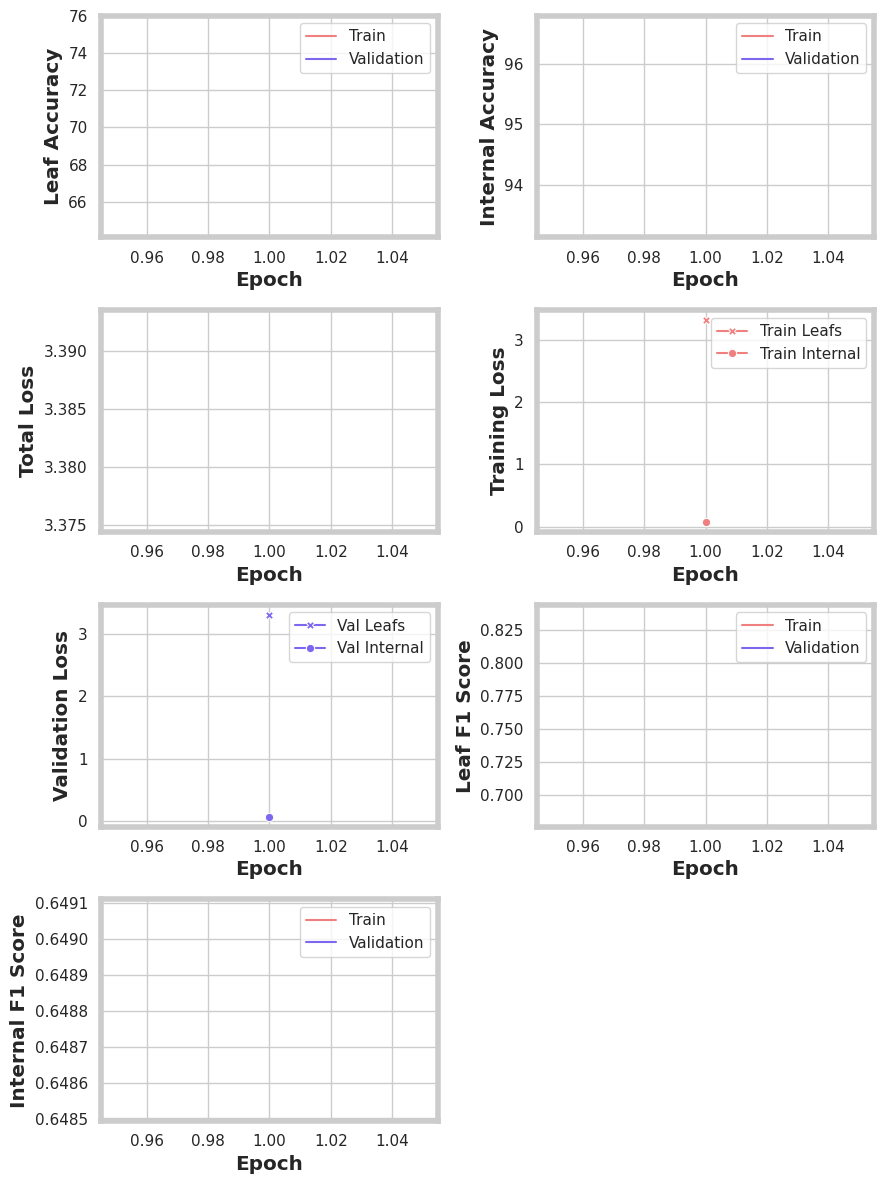

In [21]:
plot_title = today + '_results.png'


#plot_results(marginalization_dict,num_epochs,save_title='1Dec_results_hematopoietic.png')

plot_results(marginalization_dict,num_epochs)




## UMAP The Model

Running x_data through the model, then UMAP generates a UMAP plot that is quite unwiedly. BUT, this includes the internal nodes. We want to look at this for the Leaf Nodes only. 

In [21]:
# Load the classifier
checkpoint = "1_Dec_best_model"
model = Network()
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [23]:
# Load the UMAP fitter
fit = umap.UMAP()

In [ ]:
# UMAP from the FULL Hema dataset, then training only ~392k cells
# including both LEAF and INTERNAL values
# MODEL only until the last layer - no softmax

In [25]:
features = model.get_last_layer(torch.from_numpy(x_train_csr.A))

In [26]:
u = fit.fit_transform(features.detach().numpy())
u.shape

(392818, 2)

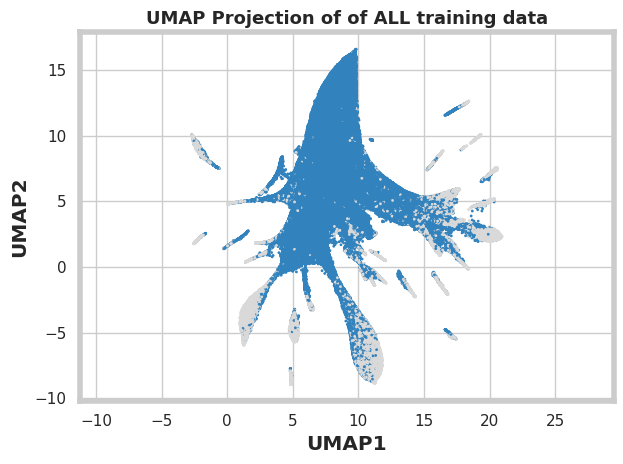

In [40]:
plt.scatter(u[:,0],u[:,1],c=y_train,cmap='tab20c',s=1)
plt.gca().set_aspect('equal', 'datalim')

#plt.colorbar(boundaries=np.arange(85))#-0.5)#.set_ticks(np.arange(52))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of of ALL training data',fontsize=13)


plt.show()


In [31]:
# UMAP from the FULL Hema dataset, then training only ~392k cells
# including ONLY LEAF values
# MODEL only until the last layer - no softmax

In [34]:
# get indices from y_train
# but first convert to a tensor 
y_train_tensor = torch.tensor(y_train)#, dtype=torch.long)

b = y_train_tensor >= 0
leaf_indices = b.nonzero().cpu().tolist()

x_train_leafonly = x_train_csr.A[leaf_indices,:].squeeze()

y_train_leafonly = y_train_tensor[y_train_tensor >= 0]
#y_train_leafonly.shape

In [35]:
features_leafonly = model.get_last_layer(torch.from_numpy(x_train_leafonly))

In [36]:
u_leafonly = fit.fit_transform(features_leafonly.detach().numpy())


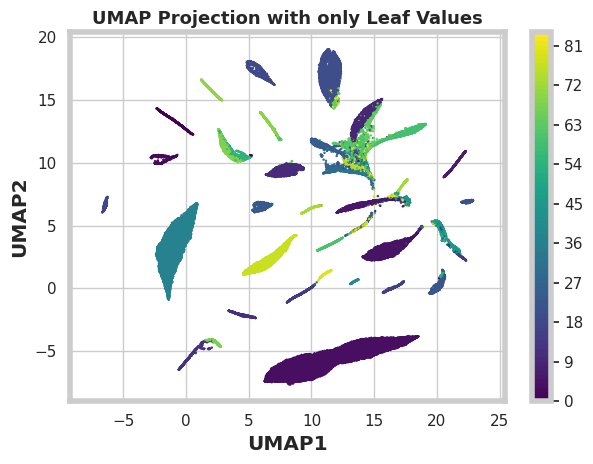

In [42]:
plt.scatter(u_leafonly[:,0],u_leafonly[:,1],c=y_train_leafonly.cpu(),cmap='viridis',s=0.5)
plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(boundaries=np.arange(85))#-0.5)#.set_ticks(np.arange(52))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection with only Leaf Values',fontsize=13)


plt.show()


In [ ]:
# try one last thing. select a small subset of the data to make sure
# the slicing works correctly

In [51]:
test_list = np.arange(1000).tolist()

In [52]:
x_train_randtest = x_train_csr.A[test_list,:].squeeze()

y_train_randtest = y_train_tensor[test_list]


In [53]:
features_randtest = model.get_last_layer(torch.from_numpy(x_train_randtest))

In [54]:
u_randtest = fit.fit_transform(features_randtest.detach().numpy())


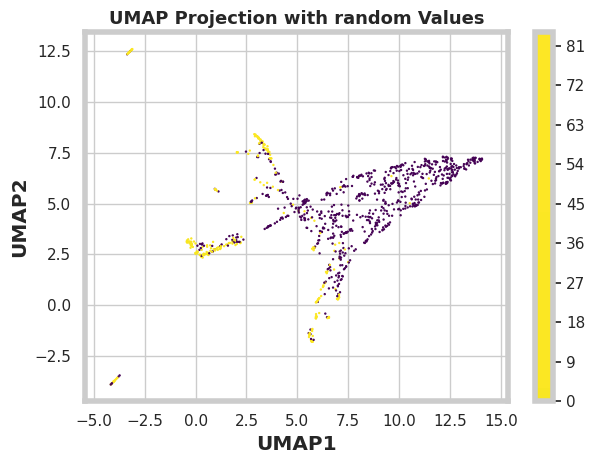

In [55]:
plt.scatter(u_randtest[:,0],u_randtest[:,1],c=y_train_randtest.cpu(),cmap='viridis',s=0.5)
plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(boundaries=np.arange(85))#-0.5)#.set_ticks(np.arange(52))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection with random Values',fontsize=13)


plt.show()
